# Solar Power Generation Data

### Tutorial for time series analysis
https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

### Data taken from 
https://www.kaggle.com/fvcoppen/solarpanelspower

### Kernel followed
https://www.kaggle.com/fvcoppen/101-univariate-and-cnn-model-on-daily-solar-power


# Business question to be asked.
1 - Given the data predict the solar power for the next year.
2 - Does seasonality - such as winter, summer, spring, etc. - plays a role in power generated per day?
3 - Is there a variation during different time of the day (morning, noon, evening)?
4 - Considering the dollar per watts charged by utility company, how much one can save in on month/one year?
5 - If total cost of installation is 25K for 5KW system, how long will it take to pay off the cost of system?



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The file PVElecGas2.csv is ';' separated and has 4 columns: 
 - Date, 
 - Cumulative solar power, 
 - used kWh electricity, 
 - used Gas m²


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import keras as K


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
print('tf version', tf.__version__)
print('keras version', K.__version__)

tf version 2.3.0
keras version 2.4.3


## Read the files

In [4]:

from pathlib import Path
# file_dir = Path('/Users/khan_m_a/Google Drive/Data_Science/Kaggle/Solar Power/data')
file_dir = Path('/content/drive/My Drive/Data_Science/Kaggle/Solar Power/data')

solarpower = pd.read_csv(file_dir / 'PV_Elec_Gas2.csv', 
                         names = ['Date', 'cum_solar_power', 'ele_kw', 'gas_mxm'],
                        skiprows = 1,
                        parse_dates = { 'dt': ['Date']},
                        index_col = 'dt')


In [5]:
solarpower.head()

,cum_solar_power,ele_kw,gas_mxm
dt,,,
2011-10-26,0.1,15.1,9.0
2011-10-27,10.2,7.4,9.2
2011-10-28,20.2,5.8,8.0
2011-10-29,29.6,4.9,6.6
2011-10-30,34.2,11.7,5.3


In [11]:
solarpower.info(), solarpower.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2948 entries, 2011-10-26 to 2019-11-20
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cum_solar_power  2948 non-null   float64
 1   ele_kw           2948 non-null   float64
 2   gas_mxm          2948 non-null   float64
dtypes: float64(3)
memory usage: 92.1 KB


(None, (2948, 3))

### Data Cleaning

##### since the second column is cumulative solar power, we need to convert into daily solar power

In [6]:
# testing shift command

small_sp = solarpower[: '2011-10-31'].copy()
small_sp_shift =  small_sp.shift(periods =1, axis=0, freq = 'D') # shift in upward

In [7]:
small_sp.head(), small_sp_shift.head()

(            cum_solar_power  ele_kw  gas_mxm
 dt                                          
 2011-10-26              0.1    15.1      9.0
 2011-10-27             10.2     7.4      9.2
 2011-10-28             20.2     5.8      8.0
 2011-10-29             29.6     4.9      6.6
 2011-10-30             34.2    11.7      5.3,
             cum_solar_power  ele_kw  gas_mxm
 dt                                          
 2011-10-27              0.1    15.1      9.0
 2011-10-28             10.2     7.4      9.2
 2011-10-29             20.2     5.8      8.0
 2011-10-30             29.6     4.9      6.6
 2011-10-31             34.2    11.7      5.3)

In [8]:
small_sp['cum_p_shift'] = small_sp_shift['cum_solar_power']
small_sp['day_solar_power'] = small_sp['cum_solar_power'].values - small_sp['cum_p_shift'].values
del small_sp['cum_solar_power'], small_sp['cum_p_shift']
small_sp

,ele_kw,gas_mxm,day_solar_power
dt,,,
2011-10-26,15.1,9.0,NaN
2011-10-27,7.4,9.2,10.1
2011-10-28,5.8,8.0,10.0
2011-10-29,4.9,6.6,9.4
2011-10-30,11.7,5.3,4.6
2011-10-31,11.0,5.7,3.8


In [9]:
solarpower_temp = solarpower.shift(periods =1, axis=0, freq='D')
solarpower['cum_p_shift'] = solarpower_temp['cum_solar_power']
solarpower['daily_solar_power'] = solarpower['cum_solar_power'] - solarpower['cum_p_shift']
solarpower.dropna(axis=0, inplace = True)

In [10]:
solarpower.head(3), solarpower.tail(3)

(            cum_solar_power  ele_kw  gas_mxm  cum_p_shift  daily_solar_power
 dt                                                                          
 2011-10-27             10.2     7.4      9.2          0.1               10.1
 2011-10-28             20.2     5.8      8.0         10.2               10.0
 2011-10-29             29.6     4.9      6.6         20.2                9.4,
             cum_solar_power  ele_kw  gas_mxm  cum_p_shift  daily_solar_power
 dt                                                                          
 2019-11-18          32238.0    13.0     14.0      32235.0                3.0
 2019-11-19          32238.0    13.0     15.0      32238.0                0.0
 2019-11-20          32244.0     9.0     16.0      32238.0                6.0)

In [11]:
# remove cum_solar_power and cum_p_shift as they are no longer needed.
solarpower.drop(['cum_p_shift', 'cum_solar_power'], 
                             axis=1, inplace = True)

In [12]:
solarpower.head(), solarpower.tail()

(            ele_kw  gas_mxm  daily_solar_power
 dt                                            
 2011-10-27     7.4      9.2               10.1
 2011-10-28     5.8      8.0               10.0
 2011-10-29     4.9      6.6                9.4
 2011-10-30    11.7      5.3                4.6
 2011-10-31    11.0      5.7                3.8,
             ele_kw  gas_mxm  daily_solar_power
 dt                                            
 2019-11-16    12.0     15.0                2.0
 2019-11-17    13.0     14.0                4.0
 2019-11-18    13.0     14.0                3.0
 2019-11-19    13.0     15.0                0.0
 2019-11-20     9.0     16.0                6.0)

### EDA

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8be163fef0>,
      dtype=object)

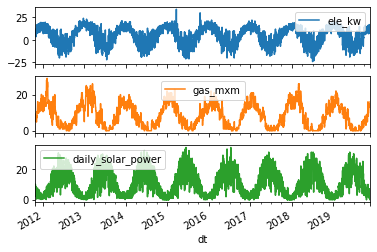

In [19]:
solarpower.plot(subplots = True)

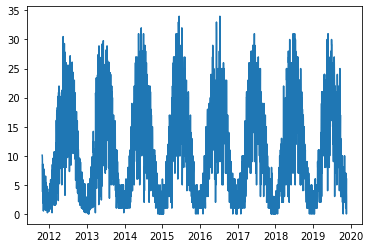

In [20]:
fig, ax = plt.subplots()
ax.plot('daily_solar_power', data = solarpower)
# plt.xlim(datetime.date(2012,1,1),datetime.date(2013,1,1) )
plt.show()

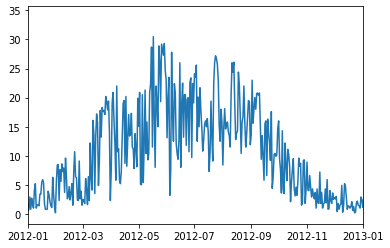

In [21]:
fig, ax = plt.subplots()
ax.plot('daily_solar_power', data = solarpower)
plt.xlim(datetime.date(2012,1,1),datetime.date(2013,1,1) )
plt.show()

As we clearly see there is a seasonality in data. During summer, the solar output is higher than winter months.

### Split the data, leaving last 365 days for validation


In [22]:
solarpower.head(), solarpower.tail(), solarpower.shape

(            ele_kw  gas_mxm  daily_solar_power
 dt                                            
 2011-10-27     7.4      9.2               10.1
 2011-10-28     5.8      8.0               10.0
 2011-10-29     4.9      6.6                9.4
 2011-10-30    11.7      5.3                4.6
 2011-10-31    11.0      5.7                3.8,
             ele_kw  gas_mxm  daily_solar_power
 dt                                            
 2019-11-16    12.0     15.0                2.0
 2019-11-17    13.0     14.0                4.0
 2019-11-18    13.0     14.0                3.0
 2019-11-19    13.0     15.0                0.0
 2019-11-20     9.0     16.0                6.0,
 (2947, 3))

In [23]:
# split and normalize data

train = solarpower[: '2018-11-20']
test = solarpower[ '2018-11-21': '2019-11-20'] # last 365 days

# as the daily power swings from 4 to 10, standardization not required
# # column normalization
train_min = train.min()
train_max = train.max()
train = ( train - train_min) / ( train_max - train_min)
test = ( test - train_min) / ( train_max - train_min)

print(type(train))
print(train.shape, test.shape)
print(train[0:5], test[0:5])

<class 'pandas.core.frame.DataFrame'>
(2582, 3) (365, 3)
              ele_kw   gas_mxm  daily_solar_power
dt                                               
2011-10-27  0.541379  0.317241           0.297059
2011-10-28  0.513793  0.275862           0.294118
2011-10-29  0.498276  0.227586           0.276471
2011-10-30  0.615517  0.182759           0.135294
2011-10-31  0.603448  0.196552           0.111765               ele_kw   gas_mxm  daily_solar_power
dt                                               
2018-11-21  0.741379  0.586207           0.029412
2018-11-22  0.655172  0.482759           0.117647
2018-11-23  0.637931  0.517241           0.147059
2018-11-24  0.637931  0.517241           0.147059
2018-11-25  0.620690  0.517241           0.058824


### Date Preparation

In [24]:
# concept taken from here
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_window(series, window):
    X, y = [], []
    no_steps = len(series) - window
    for step in range(no_steps):
        X.append(series[step : step + window])
        y.append(series[step + window])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [25]:
# test with small array
series = np.array([10,20,30,40,50,60,70,80,90])
a, b = split_window(series, 3)
print(a,b)

[[10 20 30]
 [20 30 40]
 [30 40 50]
 [40 50 60]
 [50 60 70]
 [60 70 80]] [40 50 60 70 80 90]


In [26]:
train[0:5]

,ele_kw,gas_mxm,daily_solar_power
dt,,,
2011-10-27,0.541379,0.317241,0.297059
2011-10-28,0.513793,0.275862,0.294118
2011-10-29,0.498276,0.227586,0.276471
2011-10-30,0.615517,0.182759,0.135294
2011-10-31,0.603448,0.196552,0.111765


In [27]:
# applying split_window on day_solar_power with window = 365
window = 365
train_daily_power = train['daily_solar_power'].values  # considering only daily power
X, y = split_window(train_daily_power, window)

# check couple of samples
for i in range(5):
    print(X[i][-10:], y[i])


[0.22352941 0.27941176 0.12941176 0.09117647 0.13529412 0.09411765
 0.16176471 0.28235294 0.24117647 0.25588235] 0.04411764705882353
[0.27941176 0.12941176 0.09117647 0.13529412 0.09411765 0.16176471
 0.28235294 0.24117647 0.25588235 0.04411765] 0.058823529411764705
[0.12941176 0.09117647 0.13529412 0.09411765 0.16176471 0.28235294
 0.24117647 0.25588235 0.04411765 0.05882353] 0.2705882352941257
[0.09117647 0.13529412 0.09411765 0.16176471 0.28235294 0.24117647
 0.25588235 0.04411765 0.05882353 0.27058824] 0.27352941176469786
[0.13529412 0.09411765 0.16176471 0.28235294 0.24117647 0.25588235
 0.04411765 0.05882353 0.27058824 0.27352941] 0.052941176470593584


In [28]:
print(X.shape, y.shape)

(2217, 365) (2217,)


# ARIMA MODEL

In [31]:
#Auto Regressive Integrated Moving Average Model


In [32]:
# tutorials on ARIMA model
# http://people.duke.edu/~rnau/Slides_on_ARIMA_models--Robert_Nau.pdf
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# https://www.youtube.com/watch?v=3UmyHed0iYE&ab_channel=ritvikmath
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
"""
AR(Auto Regresion), I(Integrate), MA(Moving Average)
Time series is called stationary if MA is constant (no trending up or down) and 
Variance is constant throughout the series
Integrate means create another constant Zt = a(t+1) - a(t)

ARIMA (p,d,q) --> zt = Phi1 * z(t-1) + theta1 * epsilon(t-1) + eta(t)
predicting future sales --> ak = z(k-1) + a(k-1) = sum(all Z from 1 to l) + a(l)
"""


'\nAR(Auto Regresion), I(Integrate), MA(Moving Average)\nTime series is called stationary if MA is constant (no trending up or down) and \nVariance is constant throughout the series\nIntegrate means create another constant Zt = a(t+1) - a(t)\n\nARIMA (p,d,q) --> zt = Phi1 * z(t-1) + theta1 * epsilon(t-1) + eta(t)\npredicting future sales --> ak = z(k-1) + a(k-1) = sum(all Z from 1 to l) + a(l)\n'

In [13]:
# split into train and test

dsp = solarpower['daily_solar_power']
print(dsp.head(3))
train_arima, test_arima = dsp[0:-364], dsp[-365:]# last 365 days for test

train_arima_min = train_arima.min()
train_arima_max = train_arima.max()
train_arima = ( train_arima - train_arima_min) / ( train_arima_max - train_arima_min)
test_arima = ( test_arima - train_arima_min) / ( train_arima_max - train_arima_min)


print(train_arima.shape, test_arima.shape)
print(train_arima.head(3), test_arima.head(3))

dt
2011-10-27    10.1
2011-10-28    10.0
2011-10-29     9.4
Name: daily_solar_power, dtype: float64
(2583,) (365,)
dt
2011-10-27    0.297059
2011-10-28    0.294118
2011-10-29    0.276471
Name: daily_solar_power, dtype: float64 dt
2018-11-21    0.029412
2018-11-22    0.117647
2018-11-23    0.147059
Name: daily_solar_power, dtype: float64


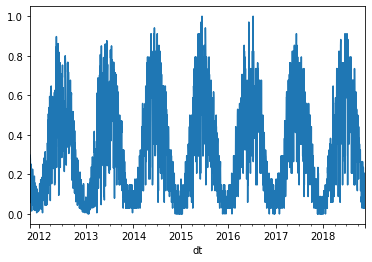

In [14]:
train_arima.plot()

In [15]:
# Test if the series is stationary or not
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
# Augmented Dickey-Fuller unit root test
# result - (test statistics, p_value, # of lags used, # of observations)

# Ho - The series is non-stationary
# HA - The series is stationary

adfuller_res_train = adfuller(train_arima)
adfuller_res_test = adfuller(test_arima)
print(adfuller_res_train)
print('p-value for train is ', adfuller_res_train[1])
print('p-value for test is ', adfuller_res_test[1])

# p-value for train is  0.030856661689697425
# p-value for test is  0.4349002506632731

# It looks like train is stationary while test is non-stationary



(-3.045518960795596, 0.030856661689697425, 19, 2563, {'1%': -3.4329039841780644, '5%': -2.8626683488356117, '10%': -2.5673706617172343}, -2705.6526120445187)
p-value for train is  0.030856661689697425
p-value for test is  0.4349002506632731


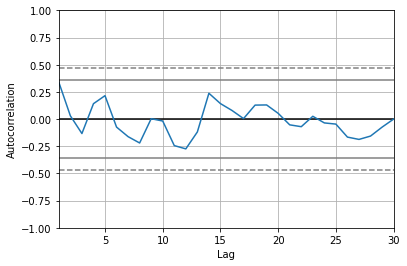

In [36]:
# auto correlation plot
# auto correlation is finding correlation with the series itself 
# with some lagged version

autocorrelation_plot(train_arima[0:30])
plt.show()

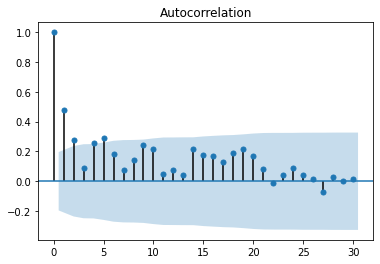

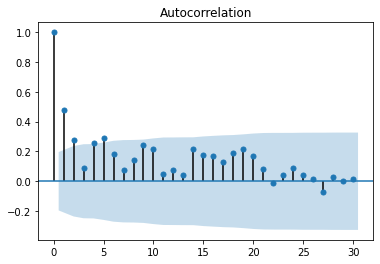

In [37]:
# ACF is similar to autocorrelation as it shows relationship between
#series with itself at another time step 

plot_acf(train_arima[0:100], lags = 30)
# the shaded area is 95% conf interval. at 1 we have autocorrelation

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                              ARIMA Model Results                              
Dep. Variable:     D.daily_solar_power   No. Observations:                 2582
Model:                  ARIMA(1, 1, 1)   Log Likelihood                1382.000
Method:                        css-mle   S.D. of innovations              0.142
Date:                 Mon, 26 Oct 2020   AIC                          -2756.000
Time:                         16:24:14   BIC                          -2732.575
Sample:                     10-28-2011   HQIC                         -2747.510
                          - 11-21-2018                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -3.191e-05      0.000     -0.070      0.944      -0.001       0.001
ar.L1.D.daily_solar_power     0.2034      0.023      8.660      0.000       0.

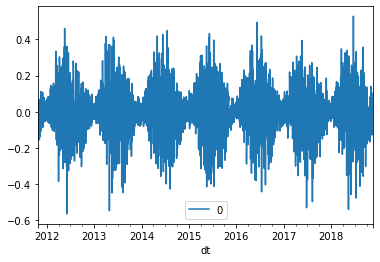

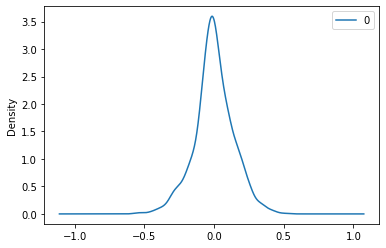

In [16]:
# ARIMA Model - used for non_stationary data
# p AR model = 1, d is differntiating = 1, MA lags = 1
model = ARIMA(train_arima,#[-366:], 
                    freq = None, order = (1, 1, 1))
model_arima = model.fit(disp = 0)  # do not display result
print(model_arima.summary())
# plotting the residuals
residuals = pd.DataFrame(model_arima.resid)
residuals.plot()
residuals.plot(kind = 'kde')

print(residuals.describe())

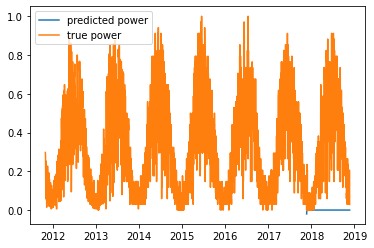

In [17]:
# lets predict last 365 day of train data
forecast_arima = model_arima.predict(start = (2582-365), end = 2582, dynamic = True)

plt.plot(forecast_arima, label = 'predicted power')

plt.plot(train_arima, label = 'true power')
plt.legend()
plt.show()

In [40]:
pd.set_option('display.max_rows', 500)
forecast_arima[-5:]

2018-11-17   -0.000032
2018-11-18   -0.000032
2018-11-19   -0.000032
2018-11-20   -0.000032
2018-11-21   -0.000032
Freq: D, dtype: float64

In [ ]:
#

# SARIMAX model

In [ ]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
#Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model


In [32]:
# SARIMAX model and fit
# pdq = 1,1,1 and P,D,Q,s = 1,1,1,5
model_sarimax = sm.tsa.statespace.SARIMAX(test_arima, order = (1,1,1),
                seasonal_order = (1,1,1, 1))
res_sarimax = model_sarimax.fit()
print(res_sarimax.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                 daily_solar_power   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 1)   Log Likelihood                 216.691
Date:                           Mon, 26 Oct 2020   AIC                           -423.383
Time:                                   16:38:26   BIC                           -403.911
Sample:                               11-21-2018   HQIC                          -415.643
                                    - 11-20-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1238      0.027      4.655      0.000       0.072       0.176
ma.L1         -0.9449      0.009   -102.072

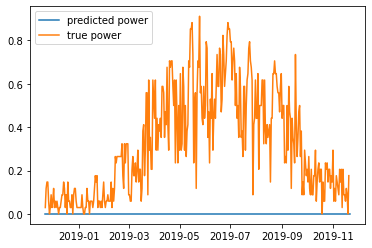

In [36]:
# lets predict last 365 day of train data

df_sarimax = test_arima.copy()

# df_sarimax['Predicted'] = res_sarimax.predict(start = (2582-365), end = 2582, dynamic = True)
df_sarimax['Predicted'] = res_sarimax.predict(start = 0, end = 365, dynamic = True)
plt.plot(df_sarimax['Predicted'], label = 'predicted power')

plt.plot(test_arima, label = 'true power')
plt.legend()
plt.show()

# Conv1D Model - Univariate input

In [50]:
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def my_conv1d_model(window, n_features = 1):
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters = 32, kernel_size = 4,
                    activation = 'relu', 
                    input_shape = (window, n_features)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(50, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mae')
#     model.summary()
    return model

In [51]:
K.backend.clear_session() # reset the previous model

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# call the model function
model_con1d = my_conv1d_model(window, n_features)

model_con1d = my_conv1d_model(window, n_features)
model_con1d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 362, 32)           160       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 181, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5792)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                289650    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 289,861
Trainable params: 289,861
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit the model

history = model_con1d.fit(X, y, epochs = 100, verbose = 0)

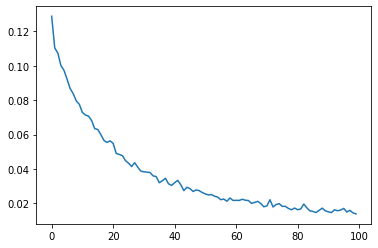

In [53]:
#plot the loss function
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [54]:
# predicting next year based on model

x_in = np.array(train.daily_solar_power[-365:]) # last 365 days
print('x_in first', x_in.shape)
#reshape to (samples, window, features) format
x_in = x_in.reshape((1, window, n_features))
print('x_in second', x_in.shape)

for i in range(365):
    y_hat = model_con1d.predict(x_in, verbose = 0)
    
    new_x = y_hat.reshape((1,1,1))
    
    x_in = np.concatenate((x_in[: , -364:], new_x), axis =1) # concatenate last 364 days with predicted value
    


x_in first (365,)
x_in second (1, 365, 1)


In [55]:
print(x_in.shape,x_in[0, 0:100, 0])

(1, 365, 1) [0.05639861 0.09107164 0.05472732 0.04120183 0.06492168 0.07464889
 0.18129727 0.2005866  0.139838   0.09381599 0.05283161 0.07346877
 0.03911778 0.03374377 0.06047461 0.12087336 0.11673965 0.06609453
 0.03077186 0.03511926 0.04567495 0.05429817 0.04423825 0.03693568
 0.0423052  0.02858729 0.04025192 0.09577347 0.06700581 0.04931059
 0.06827401 0.07420392 0.06131238 0.08884315 0.07525557 0.0844575
 0.0836135  0.07744033 0.05478727 0.05180549 0.11774062 0.07534137
 0.01073563 0.0395281  0.02202463 0.00213177 0.03049231 0.05892224
 0.05184531 0.05786898 0.02645211 0.03903055 0.0490268  0.03187061
 0.03011491 0.04999194 0.05639469 0.03377727 0.11745343 0.12413879
 0.0288645  0.04681195 0.04019595 0.06041764 0.07251173 0.03578064
 0.09882323 0.11351454 0.07184283 0.04890251 0.08641912 0.08499359
 0.10853191 0.07718997 0.03648705 0.04361975 0.0858996  0.06874575
 0.06541481 0.27620527 0.13795899 0.06356433 0.12258556 0.02842158
 0.22637664 0.16834185 0.15087175 0.13163073 0.2297

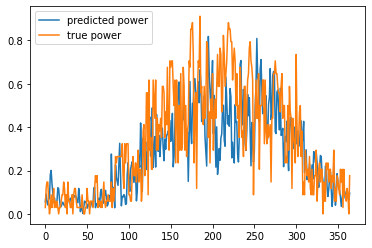

In [56]:
y_pred = x_in.reshape((x_in.shape[1]))
plt.plot(y_pred, label = 'predicted power')

y_true = test.daily_solar_power.values
plt.plot(y_true, label = 'true power')
plt.legend()
plt.show()

In [57]:
univar_r2 = r2_score(y_true, y_pred)
univar_mae = mean_absolute_error(y_true, y_pred)
print('r2 score is ', univar_r2)
print('mae is ', univar_mae)

r2 score is  0.4528053626646352
mae is  0.12807725083231505


In [58]:
# What about cumulative power

def cumulated(series, start=0):
    cm = [start]
    for i in range(len(series)):
        add_last = cm[i] + series[i]
        cm.append(add_last)
    return cm



In [59]:
temp = np.array([10,20,30,40,50,60,70,80,90])
print(cumulated(temp))

[0, 10, 30, 60, 100, 150, 210, 280, 360, 450]


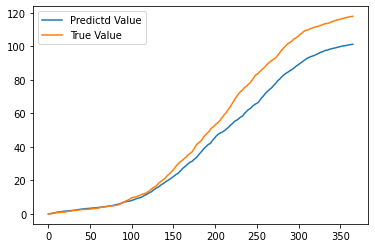

In [60]:
y_true_cum = cumulated(y_true)
y_pred_cum = cumulated(y_pred)

plt.plot(y_pred_cum, label = 'Predictd Value')
plt.plot(y_true_cum, label = 'True Value')
plt.legend()
plt.show()

In [ ]:
# accuracey after one year



# LSTM Model

In [ ]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [ ]:
solarpower.shape,X.shape, y.shape

((2947, 3), (2217, 365, 1), (2217,))

In [ ]:
# create a model function

def my_lstm_model(window, n_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, activation = 'relu',
                             input_shape = (window, n_features)),
        tf.keras.layers.Dense(1)    
        
    ])
    model.compile(optimizer = 'adam', loss = 'mse')
    
    return model


In [ ]:
print(X.shape, y.shape)

(2217, 365, 1) (2217,)


In [ ]:
# create the mode
model_lstm = my_lstm_model(window, n_features)

# fit the model

hist_lstm = model_lstm.fit(X, y, epochs = 10, verbose = 2)

Epoch 1/10
70/70 - 9s - loss: nan
Epoch 2/10
70/70 - 10s - loss: nan
Epoch 3/10
70/70 - 9s - loss: nan
Epoch 4/10
70/70 - 10s - loss: nan
Epoch 5/10
70/70 - 10s - loss: nan
Epoch 6/10
70/70 - 10s - loss: nan
Epoch 7/10
70/70 - 10s - loss: nan
Epoch 8/10
70/70 - 10s - loss: nan
Epoch 9/10
70/70 - 10s - loss: nan
Epoch 10/10
70/70 - 10s - loss: nan


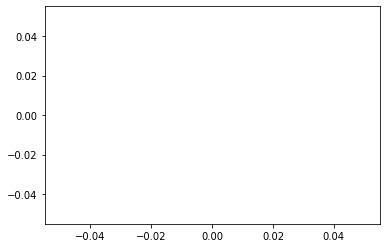

In [ ]:
#plot the loss function
import matplotlib.pyplot as plt
plt.plot(hist_lstm.history['loss'])

In [ ]:

# predicting next year based on model

x_in_lstm = np.array(train.daily_solar_power[-365:]) # last 365 days
print('x_in first', x_in_lstm.shape)
#reshape to (samples, window, features) format
x_in_lstm = x_in_lstm.reshape((1, window, n_features))
print('x_in second', x_in_lstm.shape)

for i in range(365):
    y_hat = model_lstm.predict(x_in_lstm, verbose = 0)
    
    new_x = y_hat.reshape((1,1,1))
    
    x_in_lstm = np.concatenate((x_in_lstm[: , -364:], new_x), axis =1) # concatenate last 364 days with predicted value
    

x_in first (365,)
x_in second (1, 365, 1)


In [ ]:
print(x_in_lstm.shape,x_in_lstm[0, 0:1000, 0])

(1, 365, 1) [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

In [ ]:
y_pred = x_x_in_lstmin.reshape((x_in_lstm.shape[1]))
print('y_pred size is ', y_pred.shape)
print('y_pred', y_pred[0:10])
plt.plot(y_pred, label = 'predicted power')

y_true = test.daily_solar_power.values
plt.plot(y_true, label = 'true power')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
univar_r2_lstm = r2_score(y_true, y_pred)
univar_mse_lstm = mean_absolute_error(y_true, y_pred)
print('r2 score is ', univar_r2_lstm)
print('mse is ', univar_mse_lstm)